In [1]:
import sys, os
from os.path import join, abspath, exists, pardir
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy import array as a
from astropy.table import Table
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Add, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib.colors import LogNorm

In [ ]:
train_path = "data/train.csv"
test_path = "data/test.csv"
valid_path = "data/validation.csv"

rng = np.random.default_rng(42)

# Train-Validation Split

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from tensorflow.keras.utils import to_categorical
training_data = Table.read(train_path)

classes = np.unique(training_data["class"])
class_d = dict(zip(classes,np.arange(len(classes))))
def class_to_num(c): return class_d[c]
f = np.vectorize(class_to_num)

training_data["class_id"] = f(training_data["class"])

x_train = np.stack([a(training_data[col].astype(float)) for col in ([c for c in training_data.colnames if c not in ["ID","class","class_id"]])]).T

nb_classes = len(classes)

y_train = to_categorical(a(training_data["class_id"]), nb_classes)

# x_train, y_train

In [5]:

# load validation

valid_data = Table.read(valid_path)
valid_data["class_id"] = f(valid_data["class"])

x_valid = np.stack([a(valid_data[col].astype(float)) for col in ([c for c in valid_data.colnames if c not in ["ID","class","class_id"]])]).T
y_valid = to_categorical(a(valid_data["class_id"]), nb_classes)

In [6]:
# load testing

test_data = Table.read(test_path)
test_data["class_id"] = f(test_data["class"])

x_test = np.stack([a(test_data[col].astype(float)) for col in ([c for c in test_data.colnames if c not in ["ID","class","class_id"]])]).T
y_test = to_categorical(a(test_data["class_id"]), nb_classes)

In [7]:
# normalize using the train stats

for c in range(x_train.shape[1]):
    mean, std = np.mean(x_train[:,c]), np.std(x_train[:,c])
    x_train[:,c] = (x_train[:,c]-mean) / std
    x_valid[:,c] = (x_valid[:,c]-mean) / std
    x_test[:,c] = (x_test[:,c]-mean) / std

# Model-building

In [8]:
es = EarlyStopping(patience=15,monitor="val_loss",mode="min",restore_best_weights=True,verbose=1)

In [9]:
from tensorflow.keras import metrics
f1_metric = metrics.F1Score(average='weighted')

In [10]:

inputs = Input(shape=(x_train.shape[1],))

initializer="HeNormal"
dense_activation = LeakyReLU(negative_slope=0.01)

a = 0.2 # dropout rate

neuron_num_1 = 10
neuron_num_2 = 3

# regularizer = "L2"
regularizer=None
kernel_regularizer=regularizer,

# input MLP
di = Dense(neuron_num_1,activation=dense_activation, kernel_regularizer=regularizer, kernel_initializer=initializer)(inputs)
di = Dropout(a)(di)
# di = Dense(neuron_num_1,activation=dense_activation, kernel_regularizer=regularizer, kernel_initializer=initializer)(di)
# di = Dropout(a)(di)
di = Dense(neuron_num_2,activation=dense_activation, kernel_regularizer=regularizer, kernel_initializer=initializer)(di)

# # residual block
d = Dropout(a)(di)
d = Dense(neuron_num_2,activation=dense_activation, kernel_regularizer=regularizer, kernel_initializer=initializer)(d)
d = Dropout(a)(d)
# d = Dense(neuron_num_2,activation=dense_activation, kernel_regularizer=regularizer, kernel_initializer=initializer)(d)
# d = Dropout(a)(d)
res = Add()([d,di])

# # after residual
# d2 = Dense(neuron_num_2,activation=dense_activation, kernel_regularizer=regularizer, kernel_initializer=initializer)(res)
# d2 = Dropout(a)(d2)
# d2 = Dense(neuron_num_2,activation=dense_activation, kernel_regularizer=regularizer, kernel_initializer=initializer)(d2)
# d2 = Dropout(a)(d2)

# # skip connection
# comb = Add()([di,d2])
comb = Add()([di,res])


# output = Dense(nb_classes,activation="softmax", kernel_initializer=initializer)(di)
output = Dense(nb_classes,activation="softmax", kernel_initializer=initializer)(comb)

model = Model(inputs=inputs,outputs=output)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 24)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 10)        │        250 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 10)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 3)         │         33 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 3)         │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 3)         │         12 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 3)         │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 3)         │          0 │ dropout_2[0][0],  │
│                     │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 3)         │          0 │ dense_1[0][0],    │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 9)         │         36 │ add_1[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 331 (1.29 KB)

 Trainable params: 331 (1.29 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.save("final_model.h5")

In [12]:
LR = 0.0001

model = Model(inputs=inputs,outputs=output)
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=LR), metrics=['accuracy',f1_metric])
history = model.fit(x_train, y_train, epochs=500, verbose=1, validation_data=(x_valid,y_valid), batch_size=32, callbacks=[es])

Epoch 1/500
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.0864 - f1_score: 0.0366 - loss: 8.7539 - val_accuracy: 0.0669 - val_f1_score: 0.0679 - val_loss: 3.2286
Epoch 2/500
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.1067 - f1_score: 0.0749 - loss: 3.4528 - val_accuracy: 0.1155 - val_f1_score: 0.1203 - val_loss: 2.3112
Epoch 3/500
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.1110 - f1_score: 0.0859 - loss: 2.4930 - val_accuracy: 0.1335 - val_f1_score: 0.1258 - val_loss: 2.1872
Epoch 4/500
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.1146 - f1_score: 0.0817 - loss: 2.2943 - val_accuracy: 0.1203 - val_f1_score: 0.1009 - val_loss: 2.1728
Epoch 5/500
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.1218 - f1_score: 0.0765 - loss: 2.2384 - val_accuracy: 0.1051 - val_f1_score: 0.0778 - val_loss: 2.1731
Epoch 6/500
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.1248 - f1_score: 0.0756 - loss: 2.2110 - val_accuracy: 0.0927

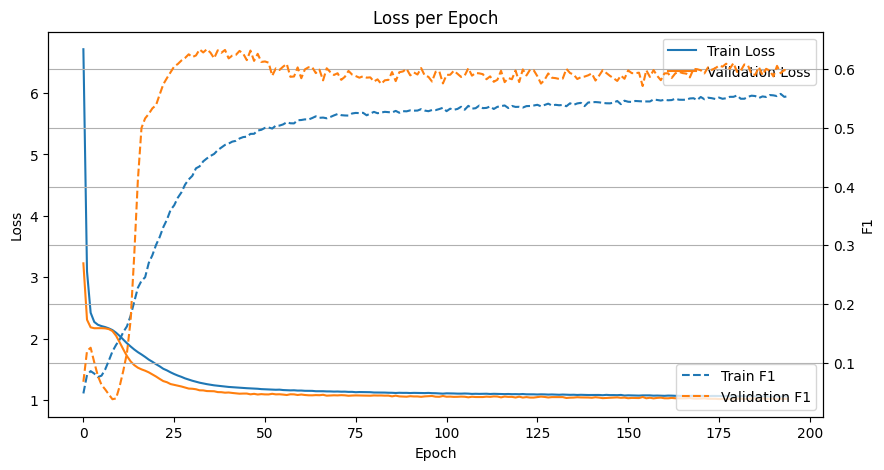

In [13]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 5))

ax2 = ax1.twinx()

train_loss = history.history['loss']
val_loss = history.history['val_loss']

ax1.plot(train_loss, label='Train Loss')
ax1.plot(val_loss, label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

train_acc = history.history['f1_score']
val_acc = history.history['val_f1_score']

ax2.plot(train_acc, label='Train F1', linestyle="dashed")
ax2.plot(val_acc, label='Validation F1', linestyle="dashed")
ax2.set_ylabel('F1')
ax2.legend()

plt.title('Loss per Epoch')
plt.grid(True)
# plt.savefig("5_layer_20n_0_0001_lr_no_dropout.png",bbox_inches="tight",dpi=300)
plt.show()

In [14]:
test_loss, test_accuracy, test_f1 = model.evaluate(x_test,y_test)

1154/1154 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5646 - f1_score: 0.6099 - loss: 1.0215


In [15]:
probas = model.predict(x_test)
preds  = np.argmax(probas,axis=1)
Y_test_dense = np.argmax(y_test, axis=1)

1154/1154 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [16]:
print("Accuracy:",accuracy_score(Y_test_dense,preds))
print("Precision:",precision_score(Y_test_dense,preds,average="macro"))
print("Recall:",recall_score(Y_test_dense,preds,average="macro"))
f1 = f1_score(Y_test_dense,preds,average="macro")
print("F1:",f1)

Accuracy: 0.5653045197281122
Precision: 0.5127108300080319
Recall: 0.605913875279096
F1: 0.5242392307200652


In [17]:
id_to_class = dict(zip(np.arange(len(classes)),classes))
def formatter(x, pos):
  return id_to_class[int(x+0.5)-1]

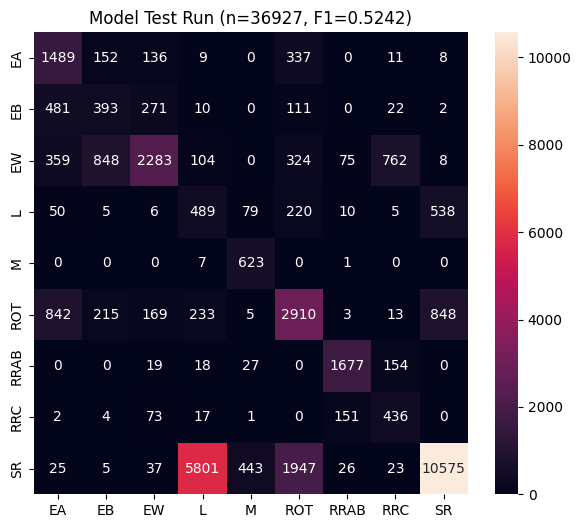

In [18]:
conf = confusion_matrix(Y_test_dense,preds)
plt.figure(figsize=(7,6))
plt.title(f"Model Test Run (n={len(y_test)}, F1={f1:.4f})")
_=sns.heatmap(conf,annot=True,fmt='d')
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_formatter(formatter)
plt.savefig("/content/model_confusion_matrix.png",dpi=300,bbox_inches="tight")